## Imports

In [54]:
from datetime import datetime

from IPython.display import display

In [80]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

In [3]:
import torch
from torch.utils.tensorboard import SummaryWriter

In [87]:
from skorch import NeuralNetRegressor, NeuralNet
from skorch.callbacks import TensorBoard, Checkpoint, EarlyStopping, EpochScoring
from skorch.dataset import Dataset, ValidSplit
from skorch.helper import predefined_split
from skorch.dataset import Dataset

In [5]:
import rtdl

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# change the defaults
sns.set()

In [7]:
import tensorwatch as tw

## Read data and visualization

In [9]:
train_data = pd.read_csv("input/tabular-playground-series-jan-2022/train.csv")
test_data = pd.read_csv("input/tabular-playground-series-jan-2022/test.csv")

In [10]:
train_data.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


,row_id,date,country,store,product,num_sold
15,15,2015-01-01,Sweden,KaggleRama,Kaggle Mug,706
33,33,2015-01-02,Sweden,KaggleRama,Kaggle Mug,653
51,51,2015-01-03,Sweden,KaggleRama,Kaggle Mug,734
69,69,2015-01-04,Sweden,KaggleRama,Kaggle Mug,657
87,87,2015-01-05,Sweden,KaggleRama,Kaggle Mug,512
105,105,2015-01-06,Sweden,KaggleRama,Kaggle Mug,471
123,123,2015-01-07,Sweden,KaggleRama,Kaggle Mug,442
141,141,2015-01-08,Sweden,KaggleRama,Kaggle Mug,493
159,159,2015-01-09,Sweden,KaggleRama,Kaggle Mug,479
177,177,2015-01-10,Sweden,KaggleRama,Kaggle Mug,536


<AxesSubplot:title={'center':'Sales for Kaggle Mug from KaggleRama, Sweden.'}, xlabel='date', ylabel='num_sold'>

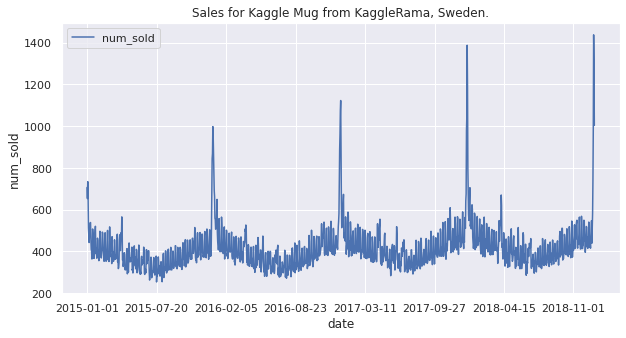

In [11]:
store_name = "KaggleRama"
country_name = "Sweden"
product_name = "Kaggle Mug"

train_data_subselect = train_data[
    (train_data['store'] == store_name) & (train_data['country'] == country_name) & (train_data['product'] == product_name)]
display(train_data_subselect.head(10))
train_data_subselect.plot(x='date', y='num_sold', ylabel='num_sold', figsize=(10, 5), title=f"Sales for {product_name} from {store_name}, {country_name}.")

In [136]:
# Sort the train_data and test_data by date, store_name, country_name, product_name
store_names = train_data.store.unique()
country_names = train_data.country.unique()
product_names = train_data['product'].unique()
print(store_names, country_names, product_names)
store_names.sort()
product_names.sort()
country_names.sort()
print(store_names, country_names, product_names)

['KaggleMart' 'KaggleRama'] ['Finland' 'Norway' 'Sweden'] ['Kaggle Mug' 'Kaggle Hat' 'Kaggle Sticker']
['KaggleMart' 'KaggleRama'] ['Finland' 'Norway' 'Sweden'] ['Kaggle Hat' 'Kaggle Mug' 'Kaggle Sticker']


In [143]:
# Sort the dataset
train_data_sorted = train_data.sort_values(by=['date', 'country', 'store', 'product'])

In [149]:
train_data_sorted.row_id.to_numpy()

array([    1,     0,     2, ..., 26296, 26295, 26297])

In [151]:
train_data

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911
...,...,...,...,...,...,...
26293,26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823
26294,26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250
26295,26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004
26296,26296,2018-12-31,Sweden,KaggleRama,Kaggle Hat,1441


In [150]:
train_data_sorted

,row_id,date,country,store,product,num_sold
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
...,...,...,...,...,...,...
26292,26292,2018-12-31,Sweden,KaggleMart,Kaggle Mug,570
26294,26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250
26296,26296,2018-12-31,Sweden,KaggleRama,Kaggle Hat,1441
26295,26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004


## Agenda

- Create X_train (feature vectors) and y_train

- Create the timesplit K-folds, let us start with K=4

- Wrap the regression model with skorch regressor class

- Train the model and tune the hyper params easily

- Method to predict the whole 1 year on test data after training

- Visualize the trained model, best way see how well we are doing

- Time series features like day of the week, month as features

- Predict on test set method, should be able to do the prediction in an iterative fashion

### Create X_train and y_train

Feature vectors are the previous 7 days of sales, their diffs, average of 7 days, std of 7 days

In [188]:
def create_features(train_data):
    store_names = train_data.store.unique()
    country_names = train_data.country.unique()
    product_names = train_data['product'].unique()
    store_names.sort()
    country_names.sort()
    product_names.sort()
    N = 7
    cat_features = ['store', 'country', 'product']
    features_list = []
    for store_name in store_names:
        for country_name in country_names:
            for product_name in product_names:
                train_data_subselect = train_data[
                            (train_data['store'] == store_name) & 
                            (train_data['country'] == country_name) & 
                            (train_data['product'] == product_name)]
                features = create_features_timeseries(train_data_subselect['num_sold'], N=7)
                features.loc[:, 'num_sold'] = np.asarray(train_data_subselect['num_sold'])[N:]
                features.loc[:, 'store'] = store_name
                features.loc[:, 'country'] = country_name
                features.loc[:, 'product'] = product_name
                features.loc[:, 'date'] = train_data_subselect.loc[:, 'date'].to_numpy()[N:]
                features.loc[:, 'row_id'] = train_data_subselect.loc[:, 'row_id'].to_numpy()[N:]
                features_list.append(features)
    features_df = pd.concat(features_list, axis=0)
    features_df.sort_values(by=['date', 'store', 'country', 'product'], inplace=True)
    return features_df

In [189]:
def create_features_timeseries(train_data_sold, N=7, feature_prefix='num_sold'):
    sales_prev = np.vstack([train_data_sold[k:-N+k] for k in range(N)]).T
    sales_prev_names = [f'{feature_prefix}_p{N-k}' for k in range(N)]
    sales_mean = np.mean(sales_prev, axis=1)
    sales_mean_names = [f'{feature_prefix}_{N}_mean']
    sales_diff = np.diff(sales_prev, axis=-1)
    sales_diff_names = [f'{feature_prefix}_d{N-k-1}' for k in range(N-1)]
    features = np.concatenate((sales_prev, sales_diff, sales_mean[:, np.newaxis]), axis=1)
    features = pd.DataFrame(features, columns=sales_prev_names + sales_diff_names + sales_mean_names)
    return features

In [201]:
# Extract the features and labels from train_data
train_features_labels = create_features(train_data)
train_labels = train_features_labels["num_sold"]
train_features_df = train_features_labels.drop("num_sold", axis=1)

# onehot encode the columns 
ct_onehot = make_column_transformer(
    (OneHotEncoder(), ['country', 'store', 'product']),
    ("drop", ["date", "row_id"]),
    remainder='passthrough'
)

train_features: np.ndarray = ct_onehot.fit_transform(train_features_df).astype(np.float32)
train_labels: np.ndarray = train_labels.astype(np.float32).to_numpy().reshape(-1, 1)

# Create train test split
X_train, X_valid, y_train, y_valid = train_test_split(
    train_features, train_labels, test_size=0.25, shuffle=False)

# Create Validation split
valid_ds = Dataset(X_valid, y_valid)
train_split = predefined_split(valid_ds)

### Train MLP model

In [98]:
# MLP Model Parameters
params = {}

params['d_in'] = 22 # Is there a way to avoid hard coding this?
params['d_layers'] = [100, 100]
params['dropout'] = 0.1
params['d_out'] = 1
params['optimizer'] = torch.optim.Adam
params['epochs'] = 50

In [203]:
# Create tensorboard writer
dateTimeObj = datetime.now()
current_date = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")

writer = SummaryWriter(log_dir=f'runs/MLP_2layer/{current_date}')

mlp_2layer_callbacks = []
mlp_2layer_callbacks.append(EarlyStopping(patience=15))
mlp_2layer_callbacks.append(Checkpoint())
mlp_2layer_callbacks.append(TensorBoard(writer))
mlp_2layer_callbacks.append(EpochScoring(scoring='r2', lower_is_better=False,
                                         name='valid_r2'))
mlp_2layer_callbacks.append(EpochScoring(scoring='neg_mean_absolute_error',
                                         lower_is_better=False, name='valid_mae'))
mlp_2layer_callbacks.append(EpochScoring(scoring='r2', lower_is_better=False, on_train=True,
                                         name='train_r2'))
mlp_2layer_callbacks.append(EpochScoring(scoring='neg_mean_absolute_error', on_train=True,
                                         lower_is_better=False, name='train_mae'))
params['callbacks'] = mlp_2layer_callbacks

In [204]:
mlp_2layer_model = NeuralNetRegressor(
    module=rtdl.MLP.make_baseline,
    module__d_in=params['d_in'],
    module__d_layers=params['d_layers'],
    module__dropout=params['dropout'],
    module__d_out=params['d_out'],
    optimizer=params['optimizer'],
    callbacks=params['callbacks'],
    train_split=train_split,
)
mlp_2layer_model.initialize()
display(mlp_2layer_model)

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MLP(
    (blocks): Sequential(
      (0): Block(
        (linear): Linear(in_features=22, out_features=100, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): Block(
        (linear): Linear(in_features=100, out_features=100, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (head): Linear(in_features=100, out_features=1, bias=True)
  ),
)

In [205]:
# TODO: Get the pipeline working :)
mlp2layer_pipe = Pipeline([
    ('scale', ct_onehot),
    ('net', mlp_2layer_model),
])

In [206]:
mlp_2layer_model.fit(X_train, y_train, epochs=params['epochs'])

Re-initializing module because the following parameters were re-set: d_in, d_layers, d_out, dropout.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    train_mae    train_r2    valid_loss    valid_mae    valid_r2    cp     dur
-------  ------------  -----------  ----------  ------------  -----------  ----------  ----  ------
      1    10338.7077     -61.8260      0.8410     4409.0703     -39.5058      0.9483     +  0.5452
      2     7102.1963     -53.0154      0.8908     3952.5085     -37.6398      0.9536     +  0.4627
      3     7496.4064     -53.7203      0.8847     3994.2316     -37.5003      0.9531        0.4756
      4     7350.0152     -53.9308      0.8870     3903.3051     -37.0538      0.9542     +  0.4828
      5     7230.5407     -53.5186      0.8888     7638.0486     -59.5730      0.9104        0.5496
      6     6606.7930     -50.5686      0.8984     4044.7099     -37.1855      0.9525        0.4635
      7     7509.6380     -54.3963      0.884

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MLP(
    (blocks): Sequential(
      (0): Block(
        (linear): Linear(in_features=22, out_features=100, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): Block(
        (linear): Linear(in_features=100, out_features=100, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (head): Linear(in_features=100, out_features=1, bias=True)
  ),
)

TODO: Why is the Validation error less than Training error?

### Validation data results visualization

Does this kind of validation makes sense, As the test set has different schema for validation?

In [233]:
def plot_validation_predictions(model, X_valid, y_valid, train_features_df):
    num_valid = y_valid.shape[0]
    valid_features_df = train_features_df.iloc[-num_valid:, :]
    valid_labels = y_valid
    train_features_labels['store']

    # pred on valid set
    y_valid_pred = model.predict(X_valid)

    # unique cat feature
    store_names = train_data.store.unique()
    country_names = train_data.country.unique()
    product_names = train_data['product'].unique()
    
    fig, axs = plt.subplots(nrows=9, ncols=2, figsize=(20, 30))
    axs = axs.flatten()

    idx = 0
    features_list = []
    for store_name in store_names:
        for country_name in country_names:
            for product_name in product_names:
                subselect_mask = ((valid_features_df['store'] == store_name) & 
                            (valid_features_df['country'] == country_name) & 
                            (valid_features_df['product'] == product_name))
                valid_features_subselect = valid_features_df[subselect_mask]
                valid_labels_subselect = valid_labels[subselect_mask]
                y_valid_pred_subselect = y_valid_pred[subselect_mask]
                axs[idx].plot(valid_features_subselect['date'], valid_labels_subselect, c='r')
                axs[idx].plot(valid_features_subselect['date'], y_valid_pred_subselect, c='b')
                axs[idx].set_title(
                    f"Store: {store_name}, Country: {country_name}, Product: {product_name}"
                )
                idx += 1
    fig.tight_layout()
    return 

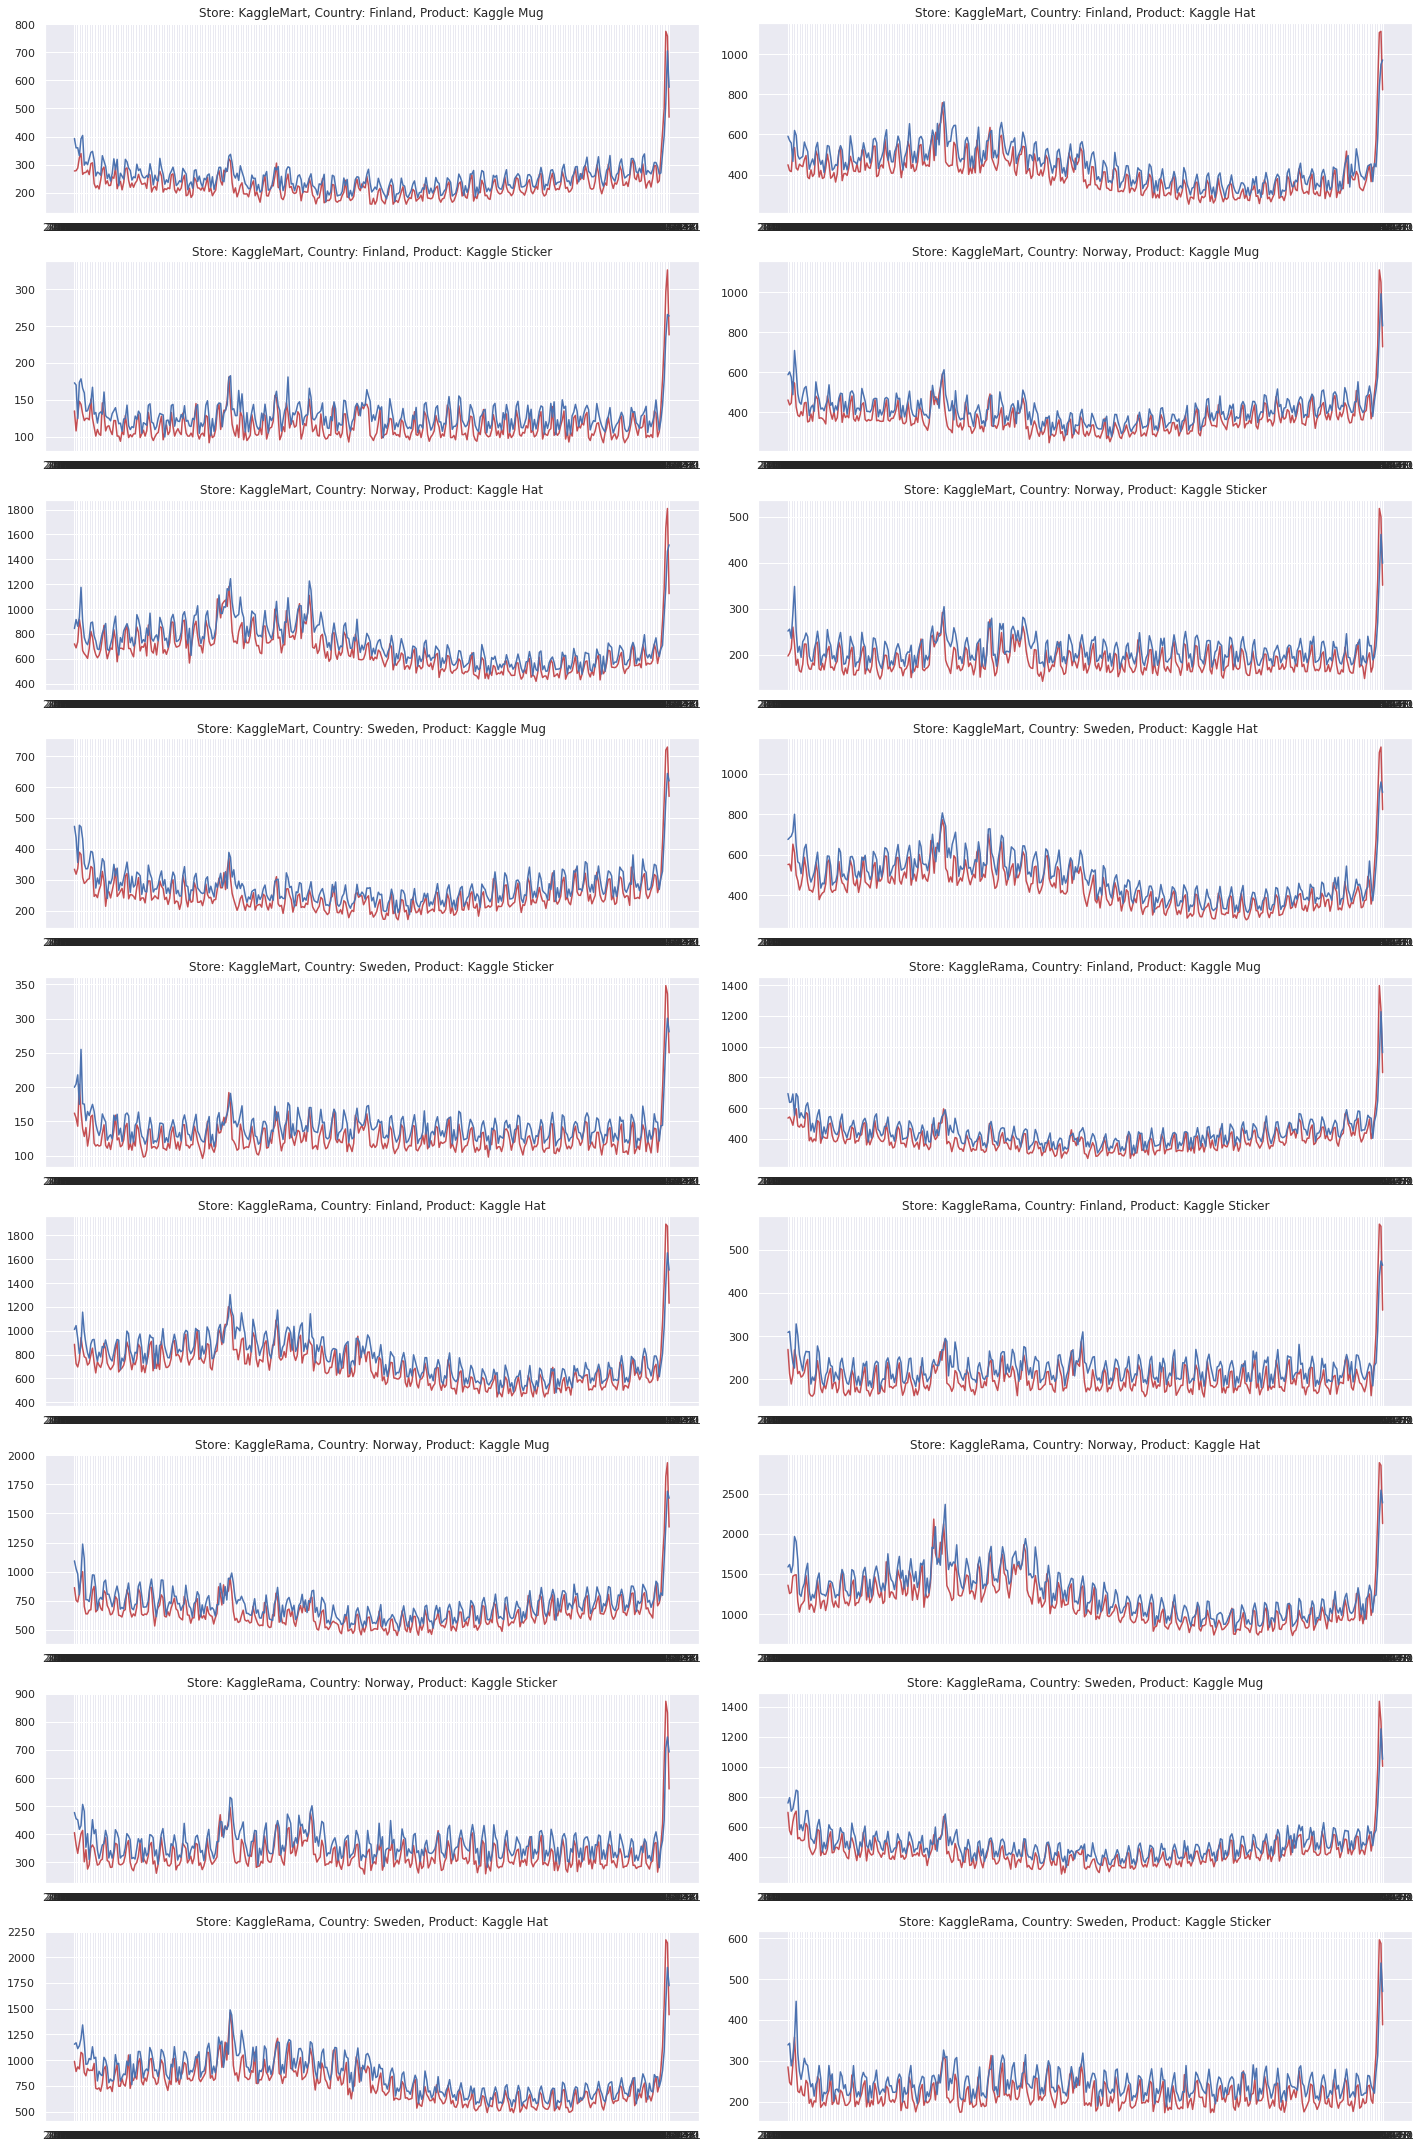

In [234]:
plot_validation_predictions(mlp_2layer_model, X_valid, y_valid, train_features_df)

We did get the trend, but we are off by quite a lot still!

### Test data prediction

_This may not be the problem we are trying!_

In [318]:
def get_today_features(test_data_withprev, idx, N=7):
    prev_data = test_data_withprev.iloc[idx-18*N:idx+18]
    store_names = test_data_withprev['store'].unique()
    country_names = test_data_withprev['country'].unique()
    product_names = test_data_withprev['product'].unique()
    store_names.sort()
    country_names.sort()
    product_names.sort()
    train_features_list = []
    for store_name in store_names:
        for country_name in country_names:
            for product_name in product_names:
                subselect_mask = ((prev_data['store'] == store_name) & 
                            (prev_data['country'] == country_name) & 
                            (prev_data['product'] == product_name))
                prev_data_subselect = prev_data[subselect_mask]
                train_features = create_features_timeseries_today(prev_data_subselect)
                train_features.loc[:, 'store'] = store_name
                train_features.loc[:, 'country'] = country_name
                train_features.loc[:, 'product'] = product_name            
                # Add the cat features!
                train_features_list.append(train_features)
    train_features_df = pd.concat(train_features_list)
    train_features_df.loc[:, 'date'] = prev_data.loc[:, 'date'].to_numpy()[-18:]
    train_features_df.loc[:, 'row_id'] = prev_data.loc[:, 'row_id'].to_numpy()[-18:]
    return train_features_df

In [322]:
def create_features_timeseries_today(train_data_sold, N=7, feature_prefix='num_sold'):
    sales_prev = train_data_sold['num_sold'].iloc[0:N].to_numpy()
    sales_prev_names = [f'{feature_prefix}_p{N-k}' for k in range(N)]
    sales_mean = np.mean(sales_prev, axis=0)
    sales_mean_names = [f'{feature_prefix}_{N}_mean']
    sales_diff = np.diff(sales_prev, axis=0)
    sales_diff_names = [f'{feature_prefix}_d{N-k-1}' for k in range(N-1)]
    features = np.concatenate((sales_prev, sales_diff, [sales_mean]), axis=0)
    features = pd.DataFrame(features.reshape(1, -1), columns=sales_prev_names + sales_diff_names + sales_mean_names)
    return features.astype(np.float32)

In [314]:
get_today_features(test_data_withprev, idx=18*7, N=7)

,num_sold_p7,num_sold_p6,num_sold_p5,num_sold_p4,num_sold_p3,num_sold_p2,num_sold_p1,num_sold_d6,num_sold_d5,num_sold_d4,num_sold_d3,num_sold_d2,num_sold_d1,num_sold_7_mean,store,country,product
0,434.0,443.0,573.0,841.0,1107.0,1113.0,822.0,9.0,130.0,268.0,266.0,6.0,-291.0,761.857143,KaggleMart,Finland,Kaggle Hat
0,243.0,331.0,414.0,499.0,774.0,757.0,469.0,88.0,83.0,85.0,275.0,-17.0,-288.0,498.142857,KaggleMart,Finland,Kaggle Mug
0,107.0,139.0,177.0,223.0,296.0,326.0,238.0,32.0,38.0,46.0,73.0,30.0,-88.0,215.142857,KaggleMart,Finland,Kaggle Sticker
0,631.0,691.0,898.0,1162.0,1650.0,1809.0,1124.0,60.0,207.0,264.0,488.0,159.0,-685.0,1137.857143,KaggleMart,Norway,Kaggle Hat
0,408.0,494.0,568.0,731.0,1113.0,1052.0,728.0,86.0,74.0,163.0,382.0,-61.0,-324.0,727.714286,KaggleMart,Norway,Kaggle Mug
0,173.0,214.0,270.0,361.0,518.0,500.0,351.0,41.0,56.0,91.0,157.0,-18.0,-149.0,341.000000,KaggleMart,Norway,Kaggle Sticker
0,404.0,543.0,672.0,874.0,1106.0,1133.0,823.0,139.0,129.0,202.0,232.0,27.0,-310.0,793.571429,KaggleMart,Sweden,Kaggle Hat
0,278.0,309.0,420.0,555.0,720.0,730.0,570.0,31.0,111.0,135.0,165.0,10.0,-160.0,511.714286,KaggleMart,Sweden,Kaggle Mug
0,129.0,143.0,196.0,260.0,348.0,336.0,250.0,14.0,53.0,64.0,88.0,-12.0,-86.0,237.428571,KaggleMart,Sweden,Kaggle Sticker
0,658.0,813.0,1068.0,1398.0,1895.0,1878.0,1231.0,155.0,255.0,330.0,497.0,-17.0,-647.0,1277.285714,KaggleRama,Finland,Kaggle Hat


In [330]:
def predict_sales(model, test_data_withprev, N=7):
    # This is an impt method, should be efficient as well!
    # Iterate over each day of the test_data
    start_idx = N*18
    for idx in range(start_idx, test_data_withprev.shape[0], 18):
        test_features = get_today_features(test_data_withprev, idx)
        X_test = ct_onehot.transform(test_features)
        y_test_pred = model.predict(X_test.astype(np.float32))
        # Use pred as true values for next day :)
        test_data_withprev['num_sold'].iloc[idx:idx+18] = y_test_pred.flatten()
    return 

In [ ]:
features.loc[:, 'date'] = train_data_subselect.loc[:, 'date'].to_numpy()[N:]
                features.loc[:, 'row_id'] = train_data_subselect.loc[:, 'row_id'].to_numpy()[N:]
                

In [308]:
test_data_withprev.sort_values(['date', 'country', 'store', 'product'], inplace=True)

In [258]:
N = 7
test_data_withprev = pd.concat(
    (train_features_labels[['row_id', 'date', 'country', 'store', 'product']].iloc[-N*18:],
    test_data), axis=0)
test_data_withprev['num_sold'] = 0 # FIXME: This is a bad way to assign things!
test_data_withprev
test_data_withprev["num_sold"].iloc[:N*18] = train_features_labels.iloc[-N*18:, :]['num_sold'].to_numpy()

/home/sarat/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [331]:
predict_sales(mlp_2layer_model, test_data_withprev)

In [334]:
test_data_withprev.iloc[7*18:][['row_id', 'num_sold']].to_csv("first_submission.csv", index=False)

In [333]:
pd.DataFrame.to_csv?

Signature:
pd.DataFrame.to_csv(
    self,
    path_or_buf: 'FilePathOrBuffer[AnyStr] | None' = None,
    sep: 'str' = ',',
    na_rep: 'str' = '',
    float_format: 'str | None' = None,
    columns: 'Sequence[Hashable] | None' = None,
    header: 'bool_t | list[str]' = True,
    index: 'bool_t' = True,
    index_label: 'IndexLabel | None' = None,
    mode: 'str' = 'w',
    encoding: 'str | None' = None,
    compression: 'CompressionOptions' = 'infer',
    quoting: 'int | None' = None,
    quotechar: 'str' = '"',
    line_terminator: 'str | None' = None,
    chunksize: 'int | None' = None,
    date_format: 'str | None' = None,
    doublequote: 'bool_t' = True,
    escapechar: 'str | None' = None,
    decimal: 'str' = '.',
    errors: 'str' = 'strict',
    storage_options: 'StorageOptions' = None,
) -> 'str | None'
Docstring:
Write object to a comma-separated values (csv) file.

Parameters
----------
path_or_buf : str or file handle, default None
    File path or object, if None is provi